In [73]:
# import this because we use custom loss function
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [74]:
from typing import List, Set, Dict, Tuple, Optional, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [75]:
#imports

import warnings
warnings.filterwarnings('ignore')

from nilmtk import DataSet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [76]:
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Flatten, BatchNormalization, Activation, Lambda, MaxPooling1D
from keras.losses import mse, binary_crossentropy, categorical_crossentropy
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
#from keras.optimizers import SGD, adam, RMSprop, Nadam, Adadelta
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam, Adadelta
from tensorflow.keras.models import load_model
from keras import backend as K

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from keras.wrappers.scikit_learn import KerasRegressor

#from read_nilmtk import read_data
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters
import pandas as pd
import numpy as np

In [77]:
def load_dataset(filename: str, resample_period :Optional[str]=None) -> pd.DataFrame:
    """
    Loads the dataset
    filename: the path to the file to load
    resample_period: (optional) the reasmple period, if None the default period of 1 second will be used
    returns: a DataFrame containing the dataset
    """
    dataset = pd.read_csv(filename, index_col='datetime').interpolate('linear')
    dataset.index = pd.to_datetime(dataset.index)
    dataset = dataset.asfreq('s')

    if resample_period:
        dataset = dataset.resample(resample_period).nearest()
    
    dataset['hour'] = dataset.index.hour + dataset.index.minute / 60 #+ dataset.index.seconde / 3600

    return dataset

In [78]:
def load_preproc_dataset():
    raw_dataset = pd.read_csv("data/house1_power_blk2_labels.csv", index_col='datetime').interpolate('linear')
    raw_dataset.index = pd.to_datetime(raw_dataset.index)
    raw_dataset = raw_dataset.asfreq('s')

    dataset_resampled = load_dataset("data/house1_power_blk2_labels.csv", "5min")
    dataset_mains_resampled = dataset_resampled["mains"]
    dataset_mains_resampled

    start_time = raw_dataset.index[0]

    #transform to numpy array of 24*356*4 elements
    M = np.array(dataset_mains_resampled)
    lenght = M.shape[0]
    M = M[:-(lenght%24)]
    M = M.reshape(lenght//24,24)

    M = M[~np.all(M == 0, axis=1)]

    M = M.reshape(len(M),24,1)
    for i in range(len(M)):
        M[i] = np.roll(M[i], -start_time.hour)

    #M = preprocessing.normalize(M)
    M = M/(max([max(x) for x in M]))

    U = []
    for x in M:
        RAN = np.array([random.uniform(0, 2) for i in range(24)])
        RAN = np.expand_dims(RAN,axis=1)
        y = x*RAN
        U.append(y)
    V = []
    for x in M:
        RAN = np.array([random.uniform(0, 2) for i in range(24)])
        RAN = np.expand_dims(RAN,axis=1)
        y = x*RAN
        V.append(y)

    for i in range(len(U)):
        U[i] = np.roll(U[i], 8)
        V[i] = np.roll(V[i], -8)

    dada = [0 for i in range(len(M))]
    x_train, x_test, _, __ = train_test_split(M, dada, test_size=0.20)
    u_train, u_test, _, __ = train_test_split(U, dada, test_size=0.20)
    v_train, v_test, _, __ = train_test_split(V, dada, test_size=0.20)

    u_train = np.array(u_train)
    u_test = np.array(u_test)

    return x_train, x_test, u_train, u_test, v_train, v_test 

In [79]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def class_preprocess(latent_test, latent_ran_test):
    L = []
    len(L)
    for x in latent_test:
        L.append([x,0])
    for x in latent_ran_test:
        L.append([x,1])

    L = np.array(L)
    np.random.shuffle(L)
    L.shape
    L[0]
    L[1]

    inputs = [x[0] for x in L]
    targets = [x[1] for x in L]
    
    print(x[0])
    
    print("-- Input --")
    print(inputs)
    
    print("\n\n-- Targets --")
    print(targets)

    return inputs, targets


In [80]:
x_train, x_test, x_train_shifted_8, x_test_shifted_8, v_train, v_test  = load_preproc_dataset()
x_train = np.squeeze(x_train, axis=2)
x_test = np.squeeze(x_test, axis=2)
x_train_shifted_8 = np.squeeze(x_train_shifted_8, axis=2)
x_test_shifted_8 = np.squeeze(x_test_shifted_8, axis=2)
v_train = np.squeeze(v_train, axis=2)
v_test = np.squeeze(v_test, axis=2)

#train_set = np.concatenate((x_train,x_train_shifted_8), axis=0)
train_set = x_train
test_set = x_test
pos_shifted_train_set = x_train_shifted_8
pos_shifted_set = x_test_shifted_8
neg_shifted_set = v_test

features_matrix_train, labels_train = class_preprocess(x_train, x_train_shifted_8)
features_matrix_train = np.array(features_matrix_train)
labels_train = np.array(labels_train)
features_matrix_test, labels_test = class_preprocess(x_test, x_test_shifted_8)
features_matrix_test = np.array(features_matrix_test)
labels_test = np.array(labels_test)

0.04290395721605867
-- Input --
[array([0.04473304, 0.04648526, 0.05534941, 0.23108637, 0.22572665,
       0.2422181 , 0.24304267, 0.2302618 , 0.24386724, 0.2436611 ,
       0.25881262, 0.24592867, 0.29313544, 0.26458462, 0.27922078,
       0.27695321, 0.26540919, 0.30457638, 0.34096063, 0.33560091,
       0.08792002, 0.08915687, 0.10719439, 0.12987013]), array([0.40059406, 0.44594383, 0.26330301, 0.05184263, 0.22691647,
       0.21271371, 0.19179176, 0.22094389, 0.07601507, 0.04727796,
       0.05781451, 0.06126854, 0.00469202, 0.07557307, 0.00484477,
       0.0824608 , 0.06189182, 0.0883766 , 0.05665053, 0.00434122,
       0.10741531, 0.509286  , 0.44535547, 0.2943336 ]), array([0.01278933, 0.01068521, 0.02837115, 0.01005974, 0.08073046,
       0.12173087, 0.0469046 , 0.02660989, 0.09333421, 0.03884059,
       0.14012804, 0.11618907, 0.00218663, 0.06807851, 0.062902  ,
       0.08740715, 0.01357976, 0.01850451, 0.09635654, 0.12266303,
       0.06470962, 0.01719157, 0.02772492, 0.0465

### Define VAE

In [81]:
def var_shallow(optimizer='Nadam', mid_activation='linear', out_activation='sigmoid', kl_coef=1):
    
    def my_vae_loss(y_true, y_pred):
        reconstruction_loss = 24*categorical_crossentropy(y_true, y_pred)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - 0.001*K.square(z_mean) - K.exp(z_log_var), axis=-1)

        vae_loss = K.mean(reconstruction_loss + kl_coef*kl_loss)
        return vae_loss


    input_window = Input(shape=(window_length,))

    z_mean = Dense(latent_size, name='z_mean', activation=mid_activation)(input_window)
    z_log_var = Dense(latent_size, name='z_log_var', activation=mid_activation)(input_window)
    
    z = Lambda(sampling, output_shape=(latent_size,), name='z')([z_mean, z_log_var])
    z = Activation('sigmoid')(z)

    decoded = Dense(window_length, activation=out_activation)(z)

    encoder = Model(input_window, [z_mean, z_log_var, z])
    autoencoder = Model(input_window, decoded)

    autoencoder.compile(optimizer=optimizer, loss=my_vae_loss)
    
    return autoencoder, encoder


## Hyperparameters

In [82]:
latent_size = 2
window_length=24
optimizer='Nadam'
mid_activation='sigmoid'
out_activation='sigmoid'

## Create and Train the AE

In [83]:
autoencoder, encoder = var_shallow()
history = autoencoder.fit(train_set, train_set,
                epochs=200,
                batch_size=32, shuffle=True)

Train on 604 samples
Epoch 1/200
604/604 [==============================] - 0s 698us/sample - loss: 215.0015
Epoch 2/200
604/604 [==============================] - 0s 58us/sample - loss: 215.1531
Epoch 3/200
604/604 [==============================] - 0s 61us/sample - loss: 215.0490
Epoch 4/200
604/604 [==============================] - 0s 46us/sample - loss: 215.1138
Epoch 5/200
604/604 [==============================] - 0s 50us/sample - loss: 215.1619
Epoch 6/200
604/604 [==============================] - 0s 51us/sample - loss: 215.2363
Epoch 7/200
604/604 [==============================] - 0s 54us/sample - loss: 215.3278
Epoch 8/200
604/604 [==============================] - 0s 59us/sample - loss: 215.3992
Epoch 9/200
604/604 [==============================] - 0s 52us/sample - loss: 215.4756
Epoch 10/200
604/604 [==============================] - 0s 54us/sample - loss: 215.6048
Epoch 11/200
604/604 [==============================] - 0s 58us/sample - loss: 215.7046
Epoch 12/200
604/60

Epoch 94/200
604/604 [==============================] - 0s 55us/sample - loss: 216.7400
Epoch 95/200
604/604 [==============================] - 0s 58us/sample - loss: 216.7372
Epoch 96/200
604/604 [==============================] - 0s 59us/sample - loss: 216.7243
Epoch 97/200
604/604 [==============================] - 0s 62us/sample - loss: 216.7130
Epoch 98/200
604/604 [==============================] - 0s 54us/sample - loss: 216.7181
Epoch 99/200
604/604 [==============================] - 0s 63us/sample - loss: 216.7066
Epoch 100/200
604/604 [==============================] - 0s 78us/sample - loss: 216.6986
Epoch 101/200
604/604 [==============================] - 0s 72us/sample - loss: 216.6959
Epoch 102/200
604/604 [==============================] - 0s 79us/sample - loss: 216.6843
Epoch 103/200
604/604 [==============================] - 0s 71us/sample - loss: 216.6742
Epoch 104/200
604/604 [==============================] - 0s 73us/sample - loss: 216.6673
Epoch 105/200
604/604 [====

604/604 [==============================] - 0s 63us/sample - loss: 216.2967
Epoch 187/200
604/604 [==============================] - 0s 68us/sample - loss: 216.2918
Epoch 188/200
604/604 [==============================] - 0s 71us/sample - loss: 216.2921
Epoch 189/200
604/604 [==============================] - 0s 69us/sample - loss: 216.2859
Epoch 190/200
604/604 [==============================] - 0s 64us/sample - loss: 216.2824
Epoch 191/200
604/604 [==============================] - 0s 59us/sample - loss: 216.2836
Epoch 192/200
604/604 [==============================] - 0s 63us/sample - loss: 216.2759
Epoch 193/200
604/604 [==============================] - 0s 66us/sample - loss: 216.2734
Epoch 194/200
604/604 [==============================] - 0s 64us/sample - loss: 216.2696
Epoch 195/200
604/604 [==============================] - 0s 66us/sample - loss: 216.2639
Epoch 196/200
604/604 [==============================] - 0s 68us/sample - loss: 216.2641
Epoch 197/200
604/604 [============

In [84]:
latent_train = encoder.predict(train_set)
latent_shifted_train = encoder.predict(pos_shifted_train_set)
latent_test = encoder.predict(test_set)
latent_shifted_pos = encoder.predict(pos_shifted_set)

print(latent_test)

#extract means
mean_train = latent_train[0]
mean_shifted_train = latent_shifted_train[0]
mean_test = latent_test[0]
mean_shifted_pos = latent_shifted_pos[0]

#extract vars
var_train = latent_train[1]
var_shifted_train = latent_shifted_train[1]
var_test = latent_test[1]
var_shifted_pos = latent_shifted_pos[1]

[array([[ 5.3688984,  5.3896055],
       [ 5.5654364,  5.5654116],
       [ 9.9822035, 10.120164 ],
       [ 5.422287 ,  5.3776855],
       [ 5.0053644,  5.0128965],
       [ 7.7648525,  7.676813 ],
       [ 7.12166  ,  7.0747776],
       [ 9.310202 ,  9.373736 ],
       [ 5.1072626,  5.0376854],
       [ 4.824024 ,  4.7817783],
       [ 4.941161 ,  4.911439 ],
       [ 6.389923 ,  6.3602715],
       [ 9.213525 ,  9.098941 ],
       [ 5.518546 ,  5.4543157],
       [ 4.9258   ,  4.9147015],
       [ 5.808159 ,  5.7664948],
       [ 5.8539314,  5.8447685],
       [ 5.485527 ,  5.424181 ],
       [ 6.8411207,  6.9110556],
       [ 7.104821 ,  7.0518084],
       [10.897645 , 11.064791 ],
       [ 4.89748  ,  4.869397 ],
       [ 5.030409 ,  4.9954805],
       [ 7.483162 ,  7.4831104],
       [ 6.6042156,  6.6071835],
       [ 8.868074 ,  8.837342 ],
       [ 5.4120398,  5.4216814],
       [ 6.570472 ,  6.6425724],
       [ 9.435577 ,  9.579293 ],
       [ 6.613737 ,  6.5872984],
       [ 

       [0.99508035, 0.9866432 ]], dtype=float32)]


In [85]:
#rearange it into a 4-dim vectors to be fed to the classifier

x,y = mean_train.T
w,z = var_train.T
c = zip(x,y,w,z)
latent_train = np.array(list(c))

x,y = mean_shifted_train.T
w,z = var_shifted_train.T
c = zip(x,y,w,z)
latent_shifted_train = np.array(list(c))

x,y = mean_test.T
w,z = var_test.T
c = zip(x,y,w,z)
latent_test = np.array(list(c))

x,y = mean_shifted_pos.T
w,z = var_shifted_pos.T
c = zip(x,y,w,z)
latent_shifted_pos = np.array(list(c))

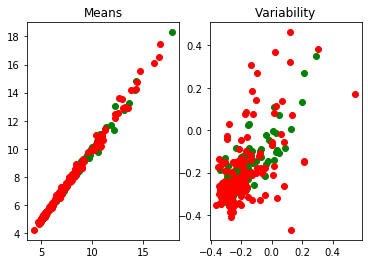

In [86]:
if latent_size == 2:
    X,Y,W,Z = latent_test.T
    XN,YN,WN,ZN = latent_shifted_pos.T
    #XNN,YNN = latent_shifted_neg.T
    plt.subplot(1, 2, 1)
    plt.plot(X, Y, 'go')
    plt.plot(XN, YN, 'ro')
    plt.title('Means')
    plt.subplot(1, 2, 2)
    plt.plot(W, Z, 'go')
    plt.plot(WN, ZN, 'ro')
    plt.title('Variability')
    #plt.plot(XNN, YNN, 'yo')
elif latent_size ==3:
    from mpl_toolkits.mplot3d import axes3d

    data = (latent_test, latent_shifted_pos,latent_shifted_neg)
    colors = ("green", "red", "yellow")
    groups = ("normal", "anomaly", "anomaly")

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax = fig.gca(projection='3d')


    #X,Y,Z = latent_test.T
    #XN,YN,ZN = latent_shifted_pos.T
    for data, color, group in zip(data, colors, groups):
        x, y, z = data.T
        ax.scatter(x, y, z, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
else:
    pass

In [87]:
#prepare latent data for classification
#train
features_matrix_train, labels_train = class_preprocess(latent_train, latent_shifted_train)
#test
features_matrix_test, labels_test = class_preprocess(latent_test, latent_shifted_pos)

5.344554
-- Input --
[array([ 4.750446  ,  4.767166  , -0.2808276 , -0.32131827], dtype=float32), array([ 6.647068  ,  6.743558  , -0.23978427, -0.18963149], dtype=float32), array([ 5.980526  ,  6.0274944 , -0.20728865, -0.24456856], dtype=float32), array([ 5.447193  ,  5.3899317 , -0.26246837, -0.250717  ], dtype=float32), array([ 4.902137  ,  4.9178505 , -0.2967679 , -0.30846637], dtype=float32), array([ 7.078368  ,  7.1165714 , -0.22758576, -0.2090716 ], dtype=float32), array([ 9.226459  ,  9.282003  , -0.11242989, -0.12650216], dtype=float32), array([ 5.135686  ,  5.1222763 , -0.30334723, -0.27718973], dtype=float32), array([ 9.158901  ,  9.168262  , -0.1046623 , -0.01046458], dtype=float32), array([ 5.2864256 ,  5.25299   , -0.29830384, -0.30217087], dtype=float32), array([12.726348  , 12.880093  ,  0.06834468,  0.03989977], dtype=float32), array([10.12723   ,  9.924114  ,  0.03574765, -0.16797265], dtype=float32), array([ 7.4514217 ,  7.335     , -0.21465762, -0.1870892 ], dtype=

In [88]:
#create and train the classifier
classifier = RandomForestClassifier()
classifier.fit(features_matrix_train, labels_train)

RandomForestClassifier()

In [89]:
#predict and evaluate
predicted_labels_test = classifier.predict(np.array(features_matrix_test))
print(confusion_matrix(labels_test,predicted_labels_test))
print(classification_report(labels_test,predicted_labels_test))

[[119  32]
 [ 53  98]]
              precision    recall  f1-score   support

           0       0.69      0.79      0.74       151
           1       0.75      0.65      0.70       151

    accuracy                           0.72       302
   macro avg       0.72      0.72      0.72       302
weighted avg       0.72      0.72      0.72       302

